In [2]:
"""Max-p regions algorithm.

Source: Wei, Ran, Sergio J. Rey, and Elijah Knaap (2020) "Efficient
regionalization for spatially explicit neighborhood delineation." International
Journal of Geographical Information Science. Accepted 2020-04-12.
"""

__author__ = ["Ran Wei", "Serge Rey", "Elijah Knaap"]
__email__ = "sjsrey@gmail.com"

from copy import deepcopy
import spopt
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import pdist, squareform

from spopt.BaseClass import BaseSpOptHeuristicSolver
from spopt.region.base import modify_components
import time
ITERCONSTRUCT = 100
ITERSA = 10


def maxp(
    gdf,
    w,
    attrs_name,
    threshold_name,
    threshold,
    top_n,
    max_iterations_construction=ITERCONSTRUCT,
    max_iterations_sa=ITERSA,
    verbose=False,
    policy="single",
    tarjan_flag = True
):
    """The max-p-regions involves the aggregation of n areas into an unknown maximum
     number of homogeneous regions, while ensuring that each region is contiguous and
     satisfies a minimum threshold value imposed on a predefined spatially extensive
    attribute.

    Parameters
    ----------

    gdf : geopandas.GeoDataFrame, required
        Geodataframe containing original data

    w : libpysal.weights.W, required
        Weights object created from given data

    attrs_name : list, required
        Strings for attribute names to measure similarity
        (cols of ``geopandas.GeoDataFrame``).

    threshold_name : string, requied
        The name of the spatial extensive attribute variable.

    threshold : {int, float}, required
        The threshold value.

    top_n : int
        Max number of candidate regions for enclave assignment.

    max_iterations_construction : int
        Max number of iterations for construction phase.

    max_iterations_SA: int
        Max number of iterations for customized simulated annealing.

    verbose : boolean
        Set to ``True`` for reporting solution progress/debugging.
        Default is ``False``.
    policy : str
        Defaults to ``single`` to attach infeasible components using a
        single linkage between the area in the infeasible component
        with the smallest nearest neighbor distance to an area in a
        feasible component. ``multiple`` adds joins for each area
        in an infeasible component and their nearest neighbor area in a
        feasible component. ``keep`` attempts to solve without
        modification (useful for debugging). ``drop`` removes areas in
        infeasible components before solving.

    Returns
    -------

    max_p : int
        The number of regions.

    labels : numpy.array
        Region IDs for observations.

    """
    gdf, w = modify_components(gdf, w, threshold_name, threshold, policy=policy)
    attr = np.atleast_2d(gdf[attrs_name].values)
    if attr.shape[0] == 1:
        attr = attr.T
    threshold_array = gdf[threshold_name].values
    distance_matrix = squareform(pdist(attr, metric="cityblock"))
    n, k = attr.shape
    arr = np.arange(n)
    cStartTime = time.time()
    max_p, rl_list = construction_phase(
        arr,
        attr,
        threshold_array,
        distance_matrix,
        w,
        threshold,
        top_n,
        max_iterations_construction,
    )
    cEndTime = time.time()
    cDuration  = cEndTime - cStartTime
    if verbose:
        print("max_p: ", max_p)
        print("number of good partitions:", len(rl_list))
        print("Construction time: ", cDuration)

    alpha = 0.998
    tabuLength = 10
    max_no_move = n
    best_obj_value = np.inf
    best_label = None
    
    for irl, rl in enumerate(rl_list):
        label, regionList, regionSpatialAttr = rl
        totalWithinRegionDistanceBeforeSA = calculate_within_region_distance(
                regionList, distance_matrix
            )
        if verbose:
            print(irl)
        for _saiter in range(max_iterations_sa):
            finalLabel, finalRegionList, finalRegionSpatialAttr = perform_sa(
                label,
                regionList,
                regionSpatialAttr,
                threshold_array,
                w,
                distance_matrix,
                threshold,
                alpha,
                tabuLength,
                max_no_move,
                tarjan_flag = tarjan_flag
            )
            totalWithinRegionDistance = calculate_within_region_distance(
                finalRegionList, distance_matrix
            )
            if verbose:
                print("totalWithinRegionDistance before SA: ")
                print(totalWithinRegionDistanceBeforeSA)
                print("totalWithinRegionDistance after SA: ")
                print(totalWithinRegionDistance)
                print("Local search time: ", (time.time() - cEndTime))
            if totalWithinRegionDistance < best_obj_value:
                best_obj_value = totalWithinRegionDistance
                best_label = finalLabel
    if verbose:
        print("best objective value:")
        print(best_obj_value)

    return max_p, best_label


def construction_phase(
    arr,
    attr,  # noqa ARG001
    threshold_array,
    distance_matrix,
    weight,
    spatialThre,
    random_assign_choice,
    max_it=999,
):
    """Construct feasible solutions for max-p-regions.

    Parameters
    ----------

    arr : array, required
        An array of index of area units.

    attr : array, required
        An array of the values of the attributes.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    weight : libpysal.weights.W, required
        Weights object created from given data.

    spatialThre : {int, float}, required
        The threshold value.

    random_assign_choice : int, required
        The number of top candidate regions to consider for enclave assignment.

    max_it : int
        Maximum number of iterations. Default is 999.

    Returns
    -------

    real_values : list
        ``realmaxpv``, ``realLabelsList``

    """
    labels_list = []
    pv_list = []
    max_p = 0
    maxp_labels = None
    maxp_regionList = None
    maxp_regionSpatialAttr = None

    for _ in range(max_it):
        labels = [0] * len(threshold_array)
        C = 0
        regionSpatialAttr = {}
        enclave = []
        regionList = {}
        np.random.shuffle(arr)

        labeledID = []
        #print("Iterateion " , _)
        failureCount = 0
        
        for arr_index in range(0, len(threshold_array)):
            P = arr[arr_index]
            if labels[P] != 0:
                continue

            NeighborPolys = deepcopy(weight.neighbors[P])

            if len(NeighborPolys) == 0:
                labels[P] = -1
            else:
                C += 1
                labeledID, spatialAttrTotal = grow_cluster_for_poly(
                    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
                )

                if spatialAttrTotal < spatialThre:
                    #print("Construction failed for ", P)
                    failureCount += 1
                    C -= 1
                    enclave.extend(labeledID)
                else:
                    regionList[C] = labeledID
                    regionSpatialAttr[C] = spatialAttrTotal
        #print("Failure count for iteration ", _, " is " , failureCount)
        num_regions = len(regionList)

        for i, _l in enumerate(labels):
            if _l == -1:
                enclave.append(i)

        if num_regions < max_p:
            continue
        else:
            max_p = num_regions
            maxp_labels, maxp_regionList, maxp_regionSpatialAttr = assign_enclave(
                enclave,
                labels,
                regionList,
                regionSpatialAttr,
                threshold_array,
                weight,
                distance_matrix,
                random_assign=random_assign_choice,
            )
            pv_list.append(max_p)
            labels_list.append([maxp_labels, maxp_regionList, maxp_regionSpatialAttr])
    realLabelsList = []
    realmaxpv = max(pv_list)
    for ipv, pv in enumerate(pv_list):
        if pv == realmaxpv:
            realLabelsList.append(labels_list[ipv])

    real_values = [realmaxpv, realLabelsList]
    return real_values


def grow_cluster_for_poly(
    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
):
    """Grow one region until threshold constraint is satisfied.

    Parameters
    ----------

    labels : list, required
        A list of current region labels

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    P : int, required
        The index of current area unit

    NeighborPolys : list, required
        The neighbors of current area unit

    C : int, required
        The index of current region

    weight : libpysal.weights.W, required
        Weights object created from given data

    spatialThre : {int, float}, required
        The threshold value.

    Returns
    -------

    cluster_info : tuple
        ``labeledID``, ``spatialAttrTotal``

    """
    labels[P] = C
    labeledID = [P]
    spatialAttrTotal = threshold_array[P]

    i = 0

    while i < len(NeighborPolys):
        if spatialAttrTotal >= spatialThre:
            break
        Pn = NeighborPolys[i]

        if labels[Pn] == 0:
            labels[Pn] = C
            labeledID.append(Pn)
            spatialAttrTotal += threshold_array[Pn]
            if spatialAttrTotal < spatialThre:
                PnNeighborPolys = weight.neighbors[Pn]
                for pnn in PnNeighborPolys:
                    if pnn not in NeighborPolys:
                        NeighborPolys.append(pnn)
        i += 1

    cluster_info = labeledID, spatialAttrTotal
    return cluster_info


def assign_enclave(
    enclave,
    labels,
    regionList,
    regionSpatialAttr,
    threshold_array,
    weight,
    distance_matrix,
    random_assign=1,
):
    """Assign the enclaves to the regions identified in the region growth phase.

    Parameters
    ----------

    enclave : list, required
        A list of enclaves.

    labels : list, required
        A list of region labels for area units.

    regionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    regionSpatialAttr : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    random_assign : int, required
        The number of top candidate regions to consider for enclave assignment.

    Returns
    -------

    region_info : list
        Deep copies of ``labels``, ``regionList``, and ``regionSpatialAttr``

    """
    enclave_index = 0
    while len(enclave) > 0:
        ec = enclave[enclave_index]
        ecNeighbors = weight.neighbors[ec]
        assignedRegion = 0
        ecNeighborsList = []

        for ecn in ecNeighbors:
            if ecn in enclave:
                continue
            rm = np.array(regionList[labels[ecn]])
            totalDistance = distance_matrix[ec, rm].sum()
            ecNeighborsList.append((ecn, totalDistance))
        ecNeighborsList = sorted(ecNeighborsList, key=lambda tup: tup[1])
        top_num = min([len(ecNeighborsList), random_assign])
        if top_num > 0:
            ecn_index = np.random.randint(top_num)
            assignedRegion = labels[ecNeighborsList[ecn_index][0]]

        if assignedRegion == 0:
            enclave_index += 1
        else:
            labels[ec] = assignedRegion
            regionList[assignedRegion].append(ec)
            regionSpatialAttr[assignedRegion] += threshold_array[ec]
            del enclave[enclave_index]
            enclave_index = 0

    region_info = [deepcopy(labels), deepcopy(regionList), deepcopy(regionSpatialAttr)]
    return region_info


def calculate_within_region_distance(regionList, distance_matrix):
    """Calculate total wthin-region distance/dissimilarity.

    Parameters
    ----------

    regionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    Returns
    -------

    totalWithinRegionDistance : {int, float}
        the total within-region distance

    """
    totalWithinRegionDistance = 0
    for _k, v in regionList.items():
        nv = np.array(v)
        regionDistance = distance_matrix[nv, :][:, nv].sum() / 2
        totalWithinRegionDistance += regionDistance

    return totalWithinRegionDistance



def check_move(
    poa,
    labels,
    regionLists,
    threshold_array,  # noqa ARG001
    weight,
    distance_matrix,
    threshold,  # noqa ARG001
):
    """Calculate the dissimilarity increase/decrease from one potential move.

    Parameters
    ----------

    poa : int, required
        The index of current area unit that can potentially move

    labels : list, required
        A list of current region labels

    regionLists : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    threshold : {int, float}, required
        The threshold value.

    Returns
    -------

    move_info : list
        ``lostDistance``, ``minAddedDistance``, and ``potentialMove``.

    """
    poaNeighbor = weight.neighbors[poa]
    donorRegion = labels[poa]

    rm = np.array(regionLists[donorRegion])
    lostDistance = distance_matrix[poa, rm].sum()
    potentialMove = None

    minAddedDistance = np.Inf
    for poan in poaNeighbor:
        recipientRegion = labels[poan]
        if donorRegion != recipientRegion:
            rm = np.array(regionLists[recipientRegion])
            addedDistance = distance_matrix[poa, rm].sum()

            if addedDistance < minAddedDistance:
                minAddedDistance = addedDistance
                potentialMove = (poa, donorRegion, recipientRegion)

    move_info = [lostDistance, minAddedDistance, potentialMove]
    return move_info


def perform_sa(
    initLabels,
    initRegionList,
    initRegionSpatialAttr,
    threshold_array,
    weight,
    distance_matrix,
    threshold,
    alpha,
    tabuLength,
    max_no_move,
    tarjan_flag = True
):
    """Perform the tabu list integrated simulated annealing algorithm.

    Parameters
    ----------

    initLabels : list, required
        A list of initial region labels before SA

    initRegionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region before SA.

    initRegionSpatialAttr : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region before SA.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    threshold : {int, float}, required
        The threshold value.

    alpha : float between 0 and 1, required
        Temperature cooling rate

    tabuLength : int, required
        Max length of a tabuList

    max_no_move : int, required
        Max number of none improving movements

    Returns
    -------

    sa_res : list
        The results from simulated annealing including ``labels``,
        ``regionLists``, and ``regionSpatialAttrs``.

    """
    t = 1
    ni_move_ct = 0
    make_move_flag = False
    tabuList = []
    potentialAreas = []

    labels = deepcopy(initLabels)
    regionLists = deepcopy(initRegionList)
    regionSpatialAttrs = deepcopy(initRegionSpatialAttr)

    while ni_move_ct <= max_no_move:
        if len(potentialAreas) == 0:
            potentialAreas = pick_move_area(
                labels,
                regionLists,
                regionSpatialAttrs,
                threshold_array,
                weight,
                distance_matrix,
                threshold,
                tarjan=tarjan_flag
            )

        if len(potentialAreas) == 0:
            break
        poa = potentialAreas[np.random.randint(len(potentialAreas))]
        lostDistance, minAddedDistance, potentialMove = check_move(
            poa,
            labels,
            regionLists,
            threshold_array,
            weight,
            distance_matrix,
            threshold,
        )

        if potentialMove is None:
            potentialAreas.remove(poa)
            continue

        diff = lostDistance - minAddedDistance
        donorRegion = potentialMove[1]
        recipientRegion = potentialMove[2]

        if diff > 0:
            make_move_flag = True
            if (poa, recipientRegion, donorRegion) not in tabuList:
                if len(tabuList) == tabuLength:
                    tabuList.pop(0)
                tabuList.append((poa, donorRegion, recipientRegion))

            ni_move_ct = 0
        else:
            ni_move_ct += 1
            prob = np.exp(diff / t)
            if prob > np.random.random() and potentialMove not in tabuList:
                make_move_flag = True
            else:
                make_move_flag = False

        potentialAreas.remove(poa)
        if make_move_flag:
            labels[poa] = recipientRegion
            regionLists[donorRegion].remove(poa)
            regionLists[recipientRegion].append(poa)
            regionSpatialAttrs[donorRegion] -= threshold_array[poa]
            regionSpatialAttrs[recipientRegion] += threshold_array[poa]

            impactedAreas = []
            for pa in potentialAreas:
                if labels[pa] == recipientRegion or labels[pa] == donorRegion:
                    impactedAreas.append(pa)
            for pa in impactedAreas:
                potentialAreas.remove(pa)

        t = t * alpha
    return [labels, regionLists, regionSpatialAttrs]



class MaxPHeuristic(BaseSpOptHeuristicSolver):
    """The max-p-regions involves the aggregation of n areas into an
    unknown maximum number of homogeneous regions, while ensuring that
    each region is contiguious and satisfies a minimum threshold value
    imposed on a predefined spatially extensive attribute.

    Parameters
    ----------

    gdf : geopandas.GeoDataFrame, required
        Geodataframe containing original data.

    w : libpysal.weights.W, required
        Weights object created from given data.

    attrs_name : list, required
        Strings for attribute names (cols of ``geopandas.GeoDataFrame``).

    threshold_name : string, required
        The name of the spatial extensive attribute variable.

    threshold : {int, float}, required
        The threshold value.

    top_n : int, required
        The number of top candidate regions to consider for enclave assignment.

    max_iterations_construction : int
        Max number of iterations for construction phase.

    max_iterations_SA : int
        Max number of iterations for customized simulated annealing.

    verbose : boolean
        Set to ``True`` for reporting solution progress/debugging.
        Default is ``False``.

    policy : str
        Defaults to ``'single'`` to attach infeasible components using a
        single linkage between the area in the infeasible component
        with the smallest nearest neighbor distance to an area in a
        feasible component. ``'multiple'`` adds joins for each area
        in an infeasible component and their nearest neighbor area in a
        feasible component. ``'keep'`` attempts to solve without
        modification (useful for debugging). ``'drop'`` removes areas in
        infeasible components before solving.

    Attributes
    ----------

    max_p : int
        The number of regions.
    labels_ : numpy.array
        Region IDs for observations.

    Examples
    --------

    >>> import numpy
    >>> import libpysal
    >>> import geopandas as gpd
    >>> from spopt.region.maxp import MaxPHeuristic

    Read the data.

    >>> pth = libpysal.examples.get_path("mexicojoin.shp")
    >>> mexico = gpd.read_file(pth)
    >>> mexico["count"] = 1

    Create the weight.

    >>> w = libpysal.weights.Queen.from_dataframe(mexico)

    Define the columns of ``geopandas.GeoDataFrame`` to be spatially
    extensive attribute.

    >>> attrs_name = [f"PCGDP{year}" for year in range(1950, 2010, 10)]

    Define the spatial extensive attribute variable and the threshold value.

    >>> threshold_name = "count"
    >>> threshold = 4

    Run the max-p-regions algorithm.

    >>> model = MaxPHeuristic(mexico, w, attrs_name, threshold_name, threshold)
    >>> model.solve()

    Get the number of regions and region IDs for unit areas.

    >>> model.p
    >>> model.labels_

    """

    def __init__(
        self,
        gdf,
        w,
        attrs_name,
        threshold_name,
        threshold,
        top_n=2,
        max_iterations_construction=99,
        max_iterations_sa=ITERSA,
        verbose=False,
        policy="single",
        tarjan_flag = True
    ):
        self.gdf = gdf
        self.w = w
        self.attrs_name = attrs_name
        self.threshold_name = threshold_name
        self.threshold = threshold
        self.top_n = top_n
        self.max_iterations_construction = max_iterations_construction
        self.max_iterations_sa = max_iterations_sa
        self.verbose = verbose
        self.policy = policy
        self.tarjan_flag = tarjan_flag

    def solve(self):
        """Solve a max-p-regions problem and get back the results."""
        max_p, label = maxp(
            self.gdf,
            self.w,
            self.attrs_name,
            self.threshold_name,
            self.threshold,
            self.top_n,
            self.max_iterations_construction,
            self.max_iterations_sa,
            verbose=self.verbose,
            policy=self.policy,
            tarjan_flag = self.tarjan_flag
        )
        self.labels_ = label
        self.p = max_p
from collections import defaultdict
def dfs(
    area_index,
    region_graph,
    visited,
    discovery_time,
    low,
    parent,
    time,
    articulation_points
):
    """The depth-first search(DFS) for the Tarjan algorithm.

    Parameters
    ----------

    area_index : int, required
        The index of area for starting the DFS

    region_graph : dict, required
        A dictionary with key as area ID and value as a list of 
        neighbor areas.

    visited : array, required
        An array that indicating whether each area has been visited

    discovery_time : array, required
        An array of the discovery time of the areas during the BFS traversal.

    low :array, required
        An array of the topmost reachable ancestor for each area in the DFS

    parent : array, required
        The array of the parent of each area in the DFS traversal
    time : int
        The time stamp of the DFS traversal

    articulation_points : list
        a list of atriculation area units which will cause the number of connected components to increase once removed.

    """
    visited[area_index] = True
    discovery_time[area_index] = time
    low[area_index] = time
    children = 0
    for neighbor_index in region_graph[area_index]:
        if not visited[neighbor_index]:
            parent[neighbor_index] = area_index
            children += 1
            dfs(neighbor_index, region_graph, visited, discovery_time, low, parent, time + 1, articulation_points)
            low[area_index] = min(low[area_index], low[neighbor_index])

            if parent[area_index] == -1 and children > 1:
                articulation_points.add(area_index)
                #print("Area" , area_index, " added as root")
            elif parent[area_index] != -1 and low[neighbor_index] >= discovery_time[area_index]:
                articulation_points.add(area_index)
                #print("Area" , area_index, " added as articluation ", parent[area_index])
        elif neighbor_index != parent[area_index]:
            low[area_index] = min(low[area_index], discovery_time[neighbor_index])
def get_articulation_points(
    areas_in_region,
    weight_sparse
): 
    """Get the articulation points out of a set of areas in a region.

    Parameters
    ----------

    areas_in_region : array, required
        The id of the areas in the region

    weight_sparse : libpysal.weights.WSP, required
        The sparse weights object created from given data

    Returns
    -------

    articulation_points : list
        A list of artulation points

    """
    edges_with_index = weight_sparse[areas_in_region, :][:, areas_in_region]
    region_graph = defaultdict(list)
    cx = coo_matrix(edges_with_index)  
    #print(cx)
    for i,j,v in zip(cx.row, cx.col, cx.data):
        region_graph[i].append(j)
    
    visited = False * areas_in_region
    #print(visited)
    discovery_time = [-1] * areas_in_region.size
    low = [-1] * areas_in_region.size
    parent = [-1] * areas_in_region.size
    #print(parent)
    time = 0
    articulation_points = set()
    for area_index in range(areas_in_region.size):
        if not visited[area_index]:
            dfs(area_index, region_graph, visited, discovery_time, low, parent, time, articulation_points)
    return list(articulation_points)

def pick_move_area(
    labels,  # noqa ARG001
    regionLists,
    regionSpatialAttrs,
    threshold_array,
    weight,
    distance_matrix,  # noqa ARG001
    threshold,
    tarjan = True
):
    """Pick a spatial unit that can move from one region to another.

    Parameters
    ----------

    labels : list, required
        A list of current region labels

    regionLists : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    regionSpatialAttrs : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight :libpysal.weights.W, required
        Weights object created from given data

    threshold : {int, float}, required
        The threshold value.
    tarjan : {boolean}
        Set to 'True' by default to use the Tarjan algorithm for picking 
        the potential areas. 1-CC method is used for each area if set to 'False'.

    Returns
    -------

    potentialAreas : list
        a list of area units that can move without violating
        contiguity and threshold constraints

    """
    potentialAreas = []
    for k, v in regionSpatialAttrs.items():
        rla = np.array(regionLists[k])
        rasa = threshold_array[rla]
        lostSA = v - rasa
        pas_indices = np.where(lostSA > threshold)[0]
        if pas_indices.size > 0:
            if tarjan:
                ap = get_articulation_points(rla, weight.sparse)
                potentialAreas.extend(list(rla[list(np.setdiff1d(pas_indices, ap))]))
            else:
                tmp_potentialArea = []
                for pasi in pas_indices:
                    leftAreas = np.delete(rla, pasi)
                    ws = weight.sparse
                    cc = connected_components(ws[leftAreas, :][:, leftAreas])
                    if cc[0] == 1:
                        tmp_potentialArea.append(rla[pasi])
                potentialAreas.extend(tmp_potentialArea)
                
                
        else:
            continue
    return potentialAreas

CPU times: total: 2.77 s
Wall time: 5.8 s


<Axes: >

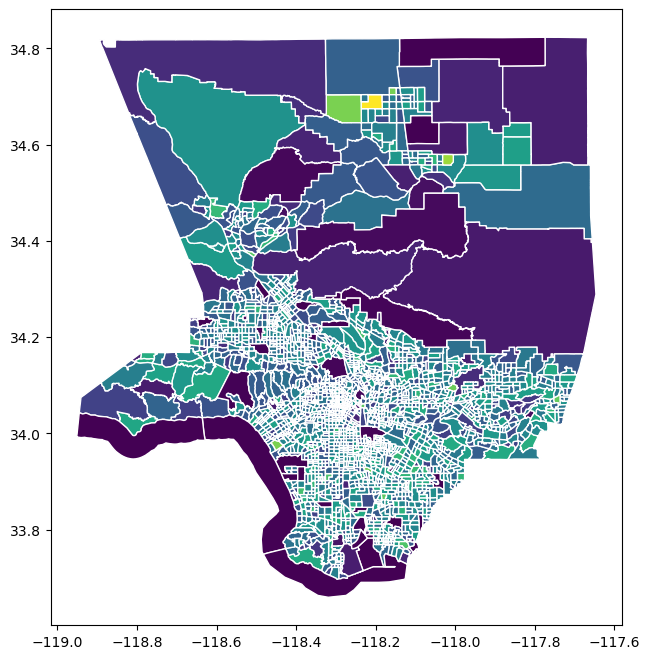

In [3]:
%%time
import geopandas
import libpysal
import numpy
path = "notebooks/data/LACounty/La_county_noisland.shp"
lacity = geopandas.read_file(path)
lacity.plot(column = 'pop2010', figsize = (12, 8), edgecolor = 'w')

In [4]:
w = libpysal.weights.Queen.from_dataframe(lacity)

C:\Users\50476\AppData\Local\Temp\ipykernel_15188\2563638906.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(lacity)


In [5]:
%%time
top_n = 2
sum_attr = 'pop2010'
sum_low = 20000.0
dis_attr = 'households'
RANDOM_SEED = 123456
numpy.random.seed(RANDOM_SEED)
model = MaxPHeuristic(lacity, w, dis_attr, sum_attr, sum_low, top_n, verbose = True, tarjan_flag = False)
model.solve()

max_p:  389
number of good partitions: 1
Construction time:  2.5801925659179688
0
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2517616.0
Local search time:  7.864114284515381
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2513696.0
Local search time:  16.755513906478882
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2536940.0
Local search time:  24.891191720962524
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2523063.0
Local search time:  33.028939723968506
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2523850.0
Local search time:  45.099910497665405
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2491282.0
Local search time:  52.79407262802124
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2455100.0
Local search time:  6

In [6]:
%%time
top_n = 2
sum_attr = 'pop2010'
sum_low = 20000.0
dis_attr = 'households'
RANDOM_SEED = 123456
numpy.random.seed(RANDOM_SEED)
model = MaxPHeuristic(lacity, w, dis_attr, sum_attr, sum_low, top_n, verbose = True, tarjan_flag = True)
model.solve()

max_p:  389
number of good partitions: 1
Construction time:  2.2791364192962646
0
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2517616.0
Local search time:  2.1561646461486816
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2513696.0
Local search time:  4.776905059814453
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2536940.0
Local search time:  7.205813407897949
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2523063.0
Local search time:  9.645619869232178
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2523850.0
Local search time:  13.326020002365112
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2491282.0
Local search time:  15.643046855926514
totalWithinRegionDistance before SA: 
3199730.0
totalWithinRegionDistance after SA: 
2455100.0
Local search time:  18

In [7]:
model = MaxPHeuristic(lacity, w, dis_attr, sum_attr, sum_low, top_n, max_iterations_construction= 999, verbose = True, tarjan_flag = True)
model.solve()

max_p:  392
number of good partitions: 2
Construction time:  21.712592124938965
0
totalWithinRegionDistance before SA: 
3295619.0
totalWithinRegionDistance after SA: 
2535805.0
Local search time:  2.5632917881011963
totalWithinRegionDistance before SA: 
3295619.0
totalWithinRegionDistance after SA: 
2501969.0
Local search time:  5.394724607467651
totalWithinRegionDistance before SA: 
3295619.0
totalWithinRegionDistance after SA: 
2530410.0
Local search time:  8.125563144683838
totalWithinRegionDistance before SA: 
3295619.0
totalWithinRegionDistance after SA: 
2530201.0
Local search time:  10.705527067184448
totalWithinRegionDistance before SA: 
3295619.0
totalWithinRegionDistance after SA: 
2521281.0
Local search time:  13.546599626541138
totalWithinRegionDistance before SA: 
3295619.0
totalWithinRegionDistance after SA: 
2573967.0
Local search time:  16.04395627975464
totalWithinRegionDistance before SA: 
3295619.0
totalWithinRegionDistance after SA: 
2566823.0
Local search time:  18

In [8]:
model.p

392

In [9]:
model.labels_

[182,
 327,
 8,
 176,
 61,
 123,
 121,
 121,
 343,
 188,
 193,
 193,
 4,
 4,
 240,
 261,
 261,
 261,
 362,
 346,
 15,
 276,
 242,
 353,
 184,
 223,
 223,
 303,
 223,
 296,
 312,
 329,
 214,
 214,
 72,
 159,
 109,
 109,
 57,
 346,
 57,
 15,
 206,
 132,
 326,
 274,
 322,
 282,
 39,
 39,
 39,
 169,
 62,
 45,
 48,
 62,
 97,
 92,
 282,
 39,
 282,
 220,
 295,
 378,
 168,
 331,
 312,
 109,
 72,
 254,
 254,
 254,
 246,
 121,
 366,
 331,
 277,
 97,
 277,
 277,
 269,
 277,
 334,
 334,
 334,
 277,
 269,
 228,
 382,
 194,
 382,
 110,
 153,
 338,
 126,
 359,
 289,
 386,
 229,
 70,
 125,
 228,
 229,
 190,
 376,
 10,
 17,
 50,
 143,
 333,
 125,
 319,
 194,
 388,
 246,
 388,
 388,
 72,
 333,
 215,
 215,
 71,
 71,
 4,
 325,
 325,
 72,
 210,
 25,
 210,
 210,
 210,
 392,
 210,
 79,
 76,
 213,
 176,
 270,
 181,
 11,
 220,
 84,
 58,
 11,
 35,
 295,
 43,
 220,
 263,
 65,
 195,
 195,
 231,
 380,
 292,
 302,
 302,
 296,
 27,
 198,
 103,
 103,
 103,
 103,
 262,
 262,
 209,
 354,
 354,
 239,
 27,
 252,
 379,
 3

In [10]:
maxp(lacity, w, dis_attr, sum_attr, sum_low, top_n)

(394,
 [304,
  368,
  82,
  9,
  4,
  205,
  183,
  381,
  366,
  18,
  332,
  332,
  98,
  9,
  214,
  193,
  193,
  199,
  52,
  307,
  19,
  247,
  156,
  374,
  353,
  353,
  110,
  211,
  110,
  159,
  226,
  53,
  63,
  10,
  10,
  10,
  10,
  296,
  328,
  231,
  307,
  307,
  394,
  89,
  209,
  209,
  209,
  115,
  343,
  295,
  295,
  309,
  348,
  187,
  278,
  348,
  263,
  137,
  115,
  309,
  295,
  279,
  2,
  50,
  292,
  292,
  63,
  296,
  226,
  7,
  87,
  7,
  140,
  381,
  190,
  146,
  259,
  259,
  259,
  259,
  163,
  163,
  259,
  259,
  238,
  163,
  263,
  305,
  190,
  299,
  190,
  61,
  61,
  360,
  64,
  90,
  135,
  135,
  100,
  303,
  174,
  138,
  100,
  100,
  175,
  56,
  234,
  234,
  149,
  149,
  213,
  325,
  25,
  140,
  230,
  230,
  230,
  227,
  149,
  130,
  130,
  352,
  352,
  214,
  377,
  260,
  227,
  316,
  215,
  215,
  215,
  215,
  157,
  215,
  72,
  112,
  112,
  112,
  320,
  288,
  83,
  348,
  276,
  355,
  43,
  58,
  163,
  

In [11]:
import itertools
#areas = np.array([747, 625, 884, 614, 623])
#areas = np.array([ 216, 1270, 1272,  217,  218,  220,  367]) #1
areas = np.array([1546, 1153, 2038, 1543, 1544, 1545,  801,  226,  799,  214])
areas = np.array([1046, 1760, 1045, 1047, 1048, 1642, 1755, 1959])
areas = np.array([ 216, 1270, 1272,  217,  218,  220,  367])
from collections import defaultdict
def dfs(
    area_index,
    region_graph,
    visited,
    discovery_time,
    low,
    parent,
    time,
    articulation_points
):
    visited[area_index] = True
    discovery_time[area_index] = time
    low[area_index] = time
    children = 0
    for neighbor_index in region_graph[area_index]:
        if not visited[neighbor_index]:
            parent[neighbor_index] = area_index
            children += 1
            dfs(neighbor_index, region_graph, visited, discovery_time, low, parent, time + 1, articulation_points)
            low[area_index] = min(low[area_index], low[neighbor_index])

            if parent[area_index] == -1 and children > 1:
                articulation_points.add(area_index)
                #print("Area" , area_index, " added as root")
            elif parent[area_index] != -1 and low[neighbor_index] >= discovery_time[area_index]:
                articulation_points.add(area_index)
                #print("Area" , area_index, " added as articluation ", parent[area_index])
        elif neighbor_index != parent[area_index]:
            low[area_index] = min(low[area_index], discovery_time[neighbor_index])
def get_articulation_points(
    areas_in_region,
    weight_sparse
): 
    """Get the articulation areas out of a region.

    Parameters
    ----------

    areas_in_region : array, required
        All the areas in the regions

    weight_sparse : dict, required
        A dictionary with key as area ID and value as a list of 
        neighbor areas.

    visited : array, required
        An array that indicating whether each area has been visited

    discovery_time : array, required
        An array of the discovery time of the areas during the BFS traversal.

    low :array, required
        An array of the topmost reachable ancestor for each area in the DFS

    parent : array, required
        The array of the parent of each area in the DFS traversal
    time : int
        The time stamp of the DFS traversal

    articulation_points : list
        a list of atriculation area units which will cause the number of connected components to increase once removed.

    """
    edges_with_index = weight_sparse[areas_in_region, :][:, areas_in_region]
    region_graph = defaultdict(list)
    cx = coo_matrix(edges_with_index)  
    #print(cx)
    for i,j,v in zip(cx.row, cx.col, cx.data):
        region_graph[i].append(j)
    
    visited = False * areas_in_region
    discovery_time = [-1] * areas_in_region.size
    low = [-1] * areas_in_region.size
    parent = [-1] * areas_in_region.size
    #print(parent)
    time = 0
    articulation_points = set()
    for area_index in range(areas_in_region.size):
        if not visited[area_index]:
            dfs(area_index, region_graph, visited, discovery_time, low, parent, time, articulation_points)
    return list(articulation_points)


print(get_articulation_points(areas, w.sparse))

[1]


In [12]:
def partial_construction_phase(
    arr,
    attr,  # noqa ARG001
    deconstruct_areas,
    threshold_array,
    distance_matrix,
    weight,
    spatialThre,
    random_assign_choice,
    max_it=99,
):
    """Construct feasible solutions for max-p-regions.

    Parameters
    ----------

    arr : array, required
        An array of index of area units.

    attr : array, required
        An array of the values of the attributes.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    weight : libpysal.weights.W, required
        Weights object created from given data.

    spatialThre : {int, float}, required
        The threshold value.

    random_assign_choice : int, required
        The number of top candidate regions to consider for enclave assignment.

    max_it : int
        Maximum number of iterations. Default is 999.

    Returns
    -------

    real_values : list
        ``realmaxpv``, ``realLabelsList``

    """
    labels_list = []
    pv_list = []
    max_p = 0
    maxp_labels = None
    maxp_regionList = None
    maxp_regionSpatialAttr = None

    for _ in range(max_it):
        labels = [-2] * len(threshold_array)
        for i in deconstruct_areas:
            labels[i] = 0
        C = 0
        regionSpatialAttr = {}
        enclave = []
        regionList = {}
        np.random.shuffle(arr)

        labeledID = []
        #print("Iterateion " , _)
        failureCount = 0
        
        for arr_index in range(0, len(threshold_array)):
            P = arr[arr_index]
            if labels[P] != 0:
                continue

            NeighborPolys = deepcopy(weight.neighbors[P])

            if len(NeighborPolys) == 0:
                labels[P] = -1
            else:
                C += 1
                labeledID, spatialAttrTotal = partial_grow_cluster_for_poly(
                    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
                )
                
                if spatialAttrTotal < spatialThre:
                    #print("Construction failed for ", P)
                    failureCount += 1
                    C -= 1
                    enclave.extend(labeledID)
                else:
                    regionList[C] = labeledID
                    regionSpatialAttr[C] = spatialAttrTotal
        #print("Failure count for iteration ", _, " is " , failureCount)
        num_regions = len(regionList)

        for i, _l in enumerate(labels):
            if _l == -1:
                enclave.append(i)

        if num_regions < max_p:
            continue
        else:
            max_p = num_regions
            maxp_labels, maxp_regionList, maxp_regionSpatialAttr = assign_enclave(
                enclave,
                labels,
                regionList,
                regionSpatialAttr,
                threshold_array,
                weight,
                distance_matrix,
                random_assign=random_assign_choice,
            )
            pv_list.append(max_p)
            labels_list.append([maxp_labels, maxp_regionList, maxp_regionSpatialAttr])
    realLabelsList = []
    realmaxpv = max(pv_list)
    for ipv, pv in enumerate(pv_list):
        if pv == realmaxpv:
            realLabelsList.append(labels_list[ipv])

    real_values = [realmaxpv, realLabelsList]
    return real_values

def partial_grow_cluster_for_poly(
    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
):
    """Grow one region until threshold constraint is satisfied.

    Parameters
    ----------

    labels : list, required
        A list of current region labels

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    P : int, required
        The index of current area unit

    NeighborPolys : list, required
        The neighbors of current area unit

    C : int, required
        The index of current region

    weight : libpysal.weights.W, required
        Weights object created from given data

    spatialThre : {int, float}, required
        The threshold value.

    Returns
    -------

    cluster_info : tuple
        ``labeledID``, ``spatialAttrTotal``

    """
    labels[P] = C
    labeledID = [P]
    spatialAttrTotal = threshold_array[P]

    i = 0

    while i < len(NeighborPolys):
        if spatialAttrTotal >= spatialThre:
            break
        Pn = NeighborPolys[i]

        if labels[Pn] == 0:
            labels[Pn] = C
            labeledID.append(Pn)
            spatialAttrTotal += threshold_array[Pn]
            if spatialAttrTotal < spatialThre:
                PnNeighborPolys = weight.neighbors[Pn]
                for pnn in PnNeighborPolys:
                    if pnn not in NeighborPolys:
                        NeighborPolys.append(pnn)
        i += 1

    cluster_info = labeledID, spatialAttrTotal
    return cluster_info


def assign_enclave(
    enclave,
    labels,
    regionList,
    regionSpatialAttr,
    threshold_array,
    weight,
    distance_matrix,
    random_assign=1,
):
    """Assign the enclaves to the regions identified in the region growth phase.

    Parameters
    ----------

    enclave : list, required
        A list of enclaves.

    labels : list, required
        A list of region labels for area units.

    regionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    regionSpatialAttr : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    random_assign : int, required
        The number of top candidate regions to consider for enclave assignment.

    Returns
    -------

    region_info : list
        Deep copies of ``labels``, ``regionList``, and ``regionSpatialAttr``

    """
    enclave_index = 0
    while len(enclave) > 0:
        #print("enclave index: ", enclave_index)
        #print("enclave list length: ", len(enclave))
        ec = enclave[enclave_index]
        ecNeighbors = weight.neighbors[ec]
        assignedRegion = 0
        ecNeighborsList = []

        for ecn in ecNeighbors:
            if ecn in enclave or labels[ecn] == -2:
                continue
            rm = np.array(regionList[labels[ecn]])
            totalDistance = distance_matrix[ec, rm].sum()
            ecNeighborsList.append((ecn, totalDistance))
        ecNeighborsList = sorted(ecNeighborsList, key=lambda tup: tup[1])
        top_num = min([len(ecNeighborsList), random_assign])
        if top_num > 0:
            ecn_index = np.random.randint(top_num)
            assignedRegion = labels[ecNeighborsList[ecn_index][0]]

        if assignedRegion == 0:
            enclave_index += 1
        else:
            labels[ec] = assignedRegion
            regionList[assignedRegion].append(ec)
            regionSpatialAttr[assignedRegion] += threshold_array[ec]
            del enclave[enclave_index]
            enclave_index = 0

    region_info = [deepcopy(labels), deepcopy(regionList), deepcopy(regionSpatialAttr)]
    return region_info

def checkResult(
        labels,
        regionAreaDic,
        regionAttrDic,
        threshold_array
):
    status = 0
    realAttrDic = dict()
    for regionId in regionAreaDic:
        regionAttrTotal = 0
        for area in regionAreaDic[regionId]:
            regionAttrTotal += threshold_array[area]
            if labels[area] != regionId:
                print("Area ", area, " is labled in region (", labels[area], ") but in the list of (", regionId, ")")
                status = -1
        if regionAttrTotal != regionAttrDic[regionId]:
                print("Region (", regionId, ") attribute does not match")
                status = -2
    print("Checking finished with status: ", status)

In [13]:
import random
gdf = lacity
attr = np.atleast_2d(gdf[dis_attr].values)
if attr.shape[0] == 1: 
    attr = attr.T
threshold_array = gdf[sum_attr].values
distance_matrix = squareform(pdist(attr, metric="cityblock"))
n, k = attr.shape
arr = np.arange(n)
c(arr,
    attr,  # noqa ARG001
    #deconstruct_areas,
    threshold_array,
    distance_matrix,
    w,
    sum_low,
    top_n,
    initial_it = 1,
    deconstruct_it = 1000,
    reconst_it = 99,
    disturbance_intensity = 5,
    max_it=1,
    verbose = True)

NameError: name 'iterated_greedy_construction' is not defined

In [ ]:
iterated_greedy_construction(arr,
    attr,  # noqa ARG001
    #deconstruct_areas,
    threshold_array,
    distance_matrix,
    w,
    sum_low,
    top_n,
    initial_it = 100,
    deconstruct_it = 0,
    reconst_it = 99,
    disturbance_intensity = 5,
    max_it=1,
    verbose = True)

Start with p:  394
Construction time:  24.913984775543213
Ends with:  394
Reconstruction time:  0.0


In [ ]:
sum(c_rl_list[0][2].values())

9754133

In [ ]:
sum(threshold_array)

9754133

In [ ]:
for irl, rl in enumerate(rl_list):
        label, regionList, regionSpatialAttr = rl
        print(regionSpatialAttr)

{1: 21355, 2: 26400, 3: 26060, 4: 26450, 5: 21041, 6: 23857}
{1: 25327, 2: 21355, 3: 20728, 4: 24029, 5: 31969, 6: 21755}
{1: 24804, 2: 26450, 3: 25980, 4: 21041, 5: 26355, 6: 20533}
{1: 31969, 2: 21136, 3: 26357, 4: 21041, 5: 23550, 6: 21110}
{1: 32106, 2: 23594, 3: 20728, 4: 26450, 5: 21824, 6: 20461}
{1: 25980, 2: 23937, 3: 26450, 4: 21136, 5: 22637, 6: 25023}
{1: 27323, 2: 22278, 3: 28383, 4: 25481, 5: 20220, 6: 21478}
{1: 26450, 2: 33085, 3: 23269, 4: 20937, 5: 21041, 6: 20381}
{1: 24804, 2: 21060, 3: 26450, 4: 26355, 5: 20469, 6: 26025}
{1: 21060, 2: 24629, 3: 22338, 4: 22524, 5: 27846, 6: 26766}
{1: 26450, 2: 23111, 3: 20625, 4: 21355, 5: 24804, 6: 28818}
{1: 20728, 2: 28889, 3: 24029, 4: 23228, 5: 24882, 6: 23407}
{1: 23376, 2: 29694, 3: 23550, 4: 24029, 5: 20828, 6: 23686}
{1: 26450, 2: 26355, 3: 24804, 4: 25980, 5: 21041, 6: 20533}
{1: 22278, 2: 23758, 3: 31969, 4: 20327, 5: 25146, 6: 21685}
{1: 24029, 2: 21060, 3: 26356, 4: 23350, 5: 26511, 6: 23857}
{1: 26904, 2: 26450, 3: 

In [ ]:
lacity["maxp_new"] = rl_list[0][0]
lacity[["maxp_new",  "pop2010"]].groupby(by="maxp_new").sum()

,pop2010
maxp_new,
-2,9600482
1,22500
2,22869
3,20530
4,20730
5,23879
6,21036
7,22107


In [ ]:
max_p

5

In [ ]:
def get_one_hop_neighbor_regions(
    regionIds,
    labels,
    weight
):
    one_hop_neighbor_set = set()

    for i in range(len(labels)):
        if labels[i] in regionIds:
            neighbor_list = [labels[j] for j in weight.neighbors[i]]
            one_hop_neighbor_set.update(neighbor_list)
    return one_hop_neighbor_set
def get_deconstruct_areas(
    regionIds,
    labels
):
    deconstruct_areas = []
    for i in range(len(labels)):
        if labels[i] in regionIds:
            deconstruct_areas.append(i)
    return deconstruct_areas
def iterated_greedy_construction(
    arr,
    attr,  # noqa ARG001
    #deconstruct_areas,
    threshold_array,
    distance_matrix,
    w,
    sum_low,
    top_n,
    initial_it = 1,
    deconstruct_it = 1000,
    reconst_it = 99,
    disturbance_intensity = 5,
    max_it=1,
    verbose = False
):
    cStartTime = time.time()
    c_max_p, c_rl_list = construction_phase(
        arr,
        attr,  # noqa ARG001
        #deconstruct_areas,
        threshold_array,
        distance_matrix,
        w,
        sum_low,
        top_n,
        max_it=initial_it,
    )
    cEndTime = time.time()
    if verbose:
        print("Start with p: ", c_max_p)
        print("Construction time: ", cEndTime - cStartTime)
    #print(c_rl_list[0][1])
    #dec_it = 1000
    #dec_count = 5
    for i in range(deconstruct_it):
        
        center_region = []
        for i in range(disturbance_intensity):
            center_region.append(numpy.random.randint(1, c_max_p))
        one_hop_regions = get_one_hop_neighbor_regions(center_region, c_rl_list[0][0], w)
        #print("Original deconstructed p: ", len(one_hop_regions), one_hop_regions)
        deconstruct_areas = get_deconstruct_areas(one_hop_regions, c_rl_list[0][0])

        deconstruct_threshold_values = [threshold_array[i] for i in deconstruct_areas]
        #print("Reconstruct ", deconstruct_areas)
        #print("Threshold attrs ", deconstruct_threshold_values)
        #print("Threshold ", sum_low)
        #print("Total attr deconstructed ", sum(deconstruct_threshold_values))

        max_p, rl_list = partial_construction_phase(
            arr,
            attr,  # noqa ARG001
            deconstruct_areas,
            threshold_array,
            distance_matrix,
            w,
            sum_low,
            top_n,
            max_it=9,
        )
        #print("Reconstructed p: ", max_p)
        #print(len(rl_list[0][1]))
        #print("Better? ", max_p > len(one_hop_regions))
        dec_region_value = 0
        dec_area_value = 0
        #print(c_rl_list[0][2])
        #checkResult(c_rl_list[0][0], c_rl_list[0][1], c_rl_list[0][2], threshold_array)
        #print(c_rl_list[0][2])
        for r in one_hop_regions:
            dec_region_value += c_rl_list[0][2][r]
        for a in deconstruct_areas:
            dec_area_value += threshold_array[a]
        #print("Valid?", dec_region_value, " ? ", dec_area_value , " ? ",sum(rl_list[0][2].values()))
        #print(rl_list[0][1])
        #print(c_max_p)
        '''print(c_rl_list[0][2])'''
        if(max_p > len(one_hop_regions)):
            p_difference = max_p - len(one_hop_regions)
            
            for i in range(1, len(one_hop_regions) + 1):
                #print(i)
                #print(list(one_hop_regions)[i-1])
                #print(i)
                #print(rl_list[0][1][i])
                for area in rl_list[0][1][i]:
                    c_rl_list[0][0][area] = list(one_hop_regions)[i-1]
                c_rl_list[0][1][list(one_hop_regions)[i-1]] = rl_list[0][1][i]
                c_rl_list[0][2][list(one_hop_regions)[i-1]] = rl_list[0][2][i]
            for i in range(len(one_hop_regions) + 1, max_p + 1):
                new_regionId = c_max_p + i - len(one_hop_regions)
                #print("New region: ", new_regionId)
                #print(rl_list[0][1][i + len(one_hop_regions)])
                for area in rl_list[0][1][i]:
                    c_rl_list[0][0][area] = new_regionId
                c_rl_list[0][1][new_regionId] = rl_list[0][1][i]
                c_rl_list[0][2][new_regionId] = rl_list[0][2][i]
            c_max_p += p_difference
    rEndTime = time.time()
    if verbose:
        print("Ends with: ", c_max_p)
        print("Reconstruction time: ", rEndTime - cEndTime)
#def update_partition(
    
#):
#print(get_deconstruct_areas(get_one_hop_neighbor_regions([1], model.labels_, w), model.labels_))


In [ ]:
target = [1]
one_hop_neighbor_set = set()
deconstruct_areas = []
for i in range(len(model.labels_)):
    if model.labels_[i] in target:
        deconstruct_areas.append(i)
print(deconstruct_areas)
for da in deconstruct_areas:
    print("Neighbors for ", da, ": ", w.neighbors[da])
    neighbor_list = [model.labels_[i] for i in w.neighbors[da]]
    print("Their region labels: ", neighbor_list)
    one_hop_neighbor_set.update(neighbor_list)
print(one_hop_neighbor_set)

[393, 1380, 1381, 1956]
Neighbors for  393 :  [1953, 1956, 324, 360, 10, 11, 626, 340, 1852]
Their region labels:  [118, 1, 365, 64, 123, 123, 64, 123, 365]
Neighbors for  1380 :  [1955, 1956, 1381, 1535, 1534, 1407]
Their region labels:  [203, 1, 1, 41, 377, 203]
Neighbors for  1381 :  [1539, 1380, 1540, 1535, 1663, 1534, 1407]
Their region labels:  [41, 1, 117, 41, 377, 377, 203]
Neighbors for  1956 :  [1536, 1955, 1380, 360, 393, 10, 626, 340, 1662, 1407]
Their region labels:  [117, 203, 1, 64, 1, 123, 64, 123, 203, 203]
{64, 1, 41, 203, 365, 117, 118, 377, 123}


In [ ]:
max_label = max(model.labels_)
area_count = 0
#total_attr = 0
region_list = []
attr_list = []
area_checkList = [0] * len(model.labels_)
for i in range(1, max_label+1):
    region_area = []
    region_attr = 0
    for j in range(len(model.labels_)):
        if model.labels_[j] == i:
            region_area.append(j)
            area_checkList[j] += 1
            region_attr += threshold_array[j]
    region_list.append(region_area)
    attr_list.append(region_attr)
    #total_attr += region_attr

In [ ]:
sum(threshold_array)

9754133

In [ ]:
region_list

[[393, 1380, 1381, 1956],
 [623, 747, 884],
 [301, 667, 1321, 1458, 1584, 1595, 1596, 1597, 1599],
 [488, 941, 1054, 1057, 1058, 2077],
 [617, 998, 1111, 1222, 1352],
 [91, 1448, 1456, 2160, 2163],
 [417, 537, 539, 1147, 1260, 1261, 1262],
 [220, 229, 367, 1270, 1272, 1392, 1395],
 [258, 746, 1051, 1641, 1798, 1875, 1876, 1878],
 [119, 120, 1909, 2022],
 [1099, 1101, 1103, 1698, 1808, 1809, 1811, 1812],
 [720, 722, 1473, 1475, 1477, 1751],
 [653, 655, 1411, 1412, 1413, 1415, 1920],
 [47, 58, 710, 881, 1501, 1503],
 [187, 1631, 1636, 1637, 2271, 2272],
 [221, 236, 240, 368, 677, 731, 902, 1018, 2141, 2142],
 [31, 1285, 1287, 1840, 1939, 2178],
 [233, 256, 369, 1224, 2122, 2151, 2251],
 [105, 658, 1418, 1419],
 [69, 70, 71, 444, 448],
 [375, 1081, 1175, 1863, 2328],
 [183, 184, 409, 523],
 [176, 1122, 1232, 1651, 2339],
 [144, 344, 1322, 1472, 2228],
 [786, 1037, 1408, 1442, 1583, 1893],
 [226, 371, 799, 801, 1153, 1544, 1545, 1546, 2037],
 [250, 251, 761, 2318, 2319],
 [467, 891, 1242, 

In [ ]:
area_checkList == [1] * len(area_checkList)

True

## Genetic Algorithm with Greedy construction
### Multiple constructions to get the set of INITIAL partitions with the maximum P value
### Genetic to improve the heterogeneity

## Iterated Local search?

In [1]:
"""Iterated Max-p regions algorithm.

The greedy construction phase is modified to adopt the iterated greedy framework.

Source: Wei, Ran, Sergio J. Rey, and Elijah Knaap (2020) "Efficient
regionalization for spatially explicit neighborhood delineation." International
Journal of Geographical Information Science. Accepted 2020-04-12.

"""

__author__ = ["Ran Wei", "Serge Rey", "Elijah Knaap"]
__email__ = "sjsrey@gmail.com"

from copy import deepcopy
import spopt
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

from spopt.BaseClass import BaseSpOptHeuristicSolver
from spopt.region.base import modify_components
import time
ITERCONSTRUCT = 100
ITERSA = 10


def iterated_maxp(
    gdf,
    w,
    attrs_name,
    threshold_name,
    threshold,
    top_n,
    max_iterations_construction=ITERCONSTRUCT,
    max_iterations_sa=ITERSA,
    verbose=False,
    policy="single",
    initial_it = 1,
    deconstruct_it = 1000,
    reconst_it = 99,
    disturbance_intensity = 0.05,
    max_it=1,
    tarjan_flag = True
):
    """The max-p-regions involves the aggregation of n areas into an unknown maximum
     number of homogeneous regions, while ensuring that each region is contiguous and
     satisfies a minimum threshold value imposed on a predefined spatially extensive
    attribute.

    Parameters
    ----------

    gdf : geopandas.GeoDataFrame, required
        Geodataframe containing original data

    w : libpysal.weights.W, required
        Weights object created from given data

    attrs_name : list, required
        Strings for attribute names to measure similarity
        (cols of ``geopandas.GeoDataFrame``).

    threshold_name : string, requied
        The name of the spatial extensive attribute variable.

    threshold : {int, float}, required
        The threshold value.

    top_n : int
        Max number of candidate regions for enclave assignment.

    max_iterations_construction : int
        Max number of iterations for construction phase.

    max_iterations_SA: int
        Max number of iterations for customized simulated annealing.

    verbose : boolean
        Set to ``True`` for reporting solution progress/debugging.
        Default is ``False``.
    policy : str
        Defaults to ``single`` to attach infeasible components using a
        single linkage between the area in the infeasible component
        with the smallest nearest neighbor distance to an area in a
        feasible component. ``multiple`` adds joins for each area
        in an infeasible component and their nearest neighbor area in a
        feasible component. ``keep`` attempts to solve without
        modification (useful for debugging). ``drop`` removes areas in
        infeasible components before solving.

    Returns
    -------

    max_p : int
        The number of regions.

    labels : numpy.array
        Region IDs for observations.

    """
    gdf, w = modify_components(gdf, w, threshold_name, threshold, policy=policy)
    attr = np.atleast_2d(gdf[attrs_name].values)
    if attr.shape[0] == 1:
        attr = attr.T
    threshold_array = gdf[threshold_name].values
    distance_matrix = squareform(pdist(attr, metric="cityblock"))
    n, k = attr.shape
    arr = np.arange(n)
    cStartTime = time.time()
    max_p, rl_list = iterated_greedy_construction(
        arr,
        attr,
        threshold_array,
        distance_matrix,
        w,
        threshold,
        top_n,
        max_iterations_construction,
    )
    cEndTime = time.time()
    cDuration  = cEndTime - cStartTime
    if verbose:
        print("max_p: ", max_p)
        print("number of good partitions:", len(rl_list))
        print("Construction time: ", cDuration)

    alpha = 0.998
    tabuLength = 10
    max_no_move = n
    best_obj_value = np.inf
    best_label = None
    
    for irl, rl in enumerate(rl_list):
        label, regionList, regionSpatialAttr = rl
        totalWithinRegionDistanceBeforeSA = calculate_within_region_distance(
                regionList, distance_matrix
            )
        if verbose:
            print(irl)
        for _saiter in range(max_iterations_sa):
            finalLabel, finalRegionList, finalRegionSpatialAttr = perform_sa(
                label,
                regionList,
                regionSpatialAttr,
                threshold_array,
                w,
                distance_matrix,
                threshold,
                alpha,
                tabuLength,
                max_no_move,
                tarjan_flag = tarjan_flag
            )
            totalWithinRegionDistance = calculate_within_region_distance(
                finalRegionList, distance_matrix
            )
            if verbose:
                print("totalWithinRegionDistance before SA: ")
                print(totalWithinRegionDistanceBeforeSA)
                print("totalWithinRegionDistance after SA: ")
                print(totalWithinRegionDistance)
                print("Local search time: ", (time.time() - cEndTime))
            if totalWithinRegionDistance < best_obj_value:
                best_obj_value = totalWithinRegionDistance
                best_label = finalLabel
    if verbose:
        print("best objective value:")
        print(best_obj_value)

    return max_p, best_label


def construction_phase(
    arr,
    attr,  # noqa ARG001
    threshold_array,
    distance_matrix,
    weight,
    spatialThre,
    random_assign_choice,
    max_it=999,
):
    """Construct feasible solutions for max-p-regions.

    Parameters
    ----------

    arr : array, required
        An array of index of area units.

    attr : array, required
        An array of the values of the attributes.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    weight : libpysal.weights.W, required
        Weights object created from given data.

    spatialThre : {int, float}, required
        The threshold value.

    random_assign_choice : int, required
        The number of top candidate regions to consider for enclave assignment.

    max_it : int
        Maximum number of iterations. Default is 999.

    Returns
    -------

    real_values : list
        ``realmaxpv``, ``realLabelsList``

    """
    labels_list = []
    pv_list = []
    max_p = 0
    maxp_labels = None
    maxp_regionList = None
    maxp_regionSpatialAttr = None

    for _ in range(max_it):
        labels = [0] * len(threshold_array)
        C = 0
        regionSpatialAttr = {}
        enclave = []
        regionList = {}
        np.random.shuffle(arr)

        labeledID = []
        #print("Iterateion " , _)
        failureCount = 0
        
        for arr_index in range(0, len(threshold_array)):
            P = arr[arr_index]
            if labels[P] != 0:
                continue

            NeighborPolys = deepcopy(weight.neighbors[P])

            if len(NeighborPolys) == 0:
                labels[P] = -1
            else:
                C += 1
                labeledID, spatialAttrTotal = grow_cluster_for_poly(
                    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
                )

                if spatialAttrTotal < spatialThre:
                    #print("Construction failed for ", P)
                    failureCount += 1
                    C -= 1
                    enclave.extend(labeledID)
                else:
                    regionList[C] = labeledID
                    regionSpatialAttr[C] = spatialAttrTotal
        #print("Failure count for iteration ", _, " is " , failureCount)
        num_regions = len(regionList)

        for i, _l in enumerate(labels):
            if _l == -1:
                enclave.append(i)

        if num_regions < max_p:
            continue
        else:
            max_p = num_regions
            maxp_labels, maxp_regionList, maxp_regionSpatialAttr = assign_enclave(
                enclave,
                labels,
                regionList,
                regionSpatialAttr,
                threshold_array,
                weight,
                distance_matrix,
                random_assign=random_assign_choice,
            )
            pv_list.append(max_p)
            labels_list.append([maxp_labels, maxp_regionList, maxp_regionSpatialAttr])
    realLabelsList = []
    realmaxpv = max(pv_list)
    for ipv, pv in enumerate(pv_list):
        if pv == realmaxpv:
            realLabelsList.append(labels_list[ipv])

    real_values = [realmaxpv, realLabelsList]
    return real_values


def grow_cluster_for_poly(
    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
):
    """Grow one region until threshold constraint is satisfied.

    Parameters
    ----------

    labels : list, required
        A list of current region labels

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    P : int, required
        The index of current area unit

    NeighborPolys : list, required
        The neighbors of current area unit

    C : int, required
        The index of current region

    weight : libpysal.weights.W, required
        Weights object created from given data

    spatialThre : {int, float}, required
        The threshold value.

    Returns
    -------

    cluster_info : tuple
        ``labeledID``, ``spatialAttrTotal``

    """
    labels[P] = C
    labeledID = [P]
    spatialAttrTotal = threshold_array[P]

    i = 0

    while i < len(NeighborPolys):
        if spatialAttrTotal >= spatialThre:
            break
        Pn = NeighborPolys[i]

        if labels[Pn] == 0:
            labels[Pn] = C
            labeledID.append(Pn)
            spatialAttrTotal += threshold_array[Pn]
            if spatialAttrTotal < spatialThre:
                PnNeighborPolys = weight.neighbors[Pn]
                for pnn in PnNeighborPolys:
                    if pnn not in NeighborPolys:
                        NeighborPolys.append(pnn)
        i += 1

    cluster_info = labeledID, spatialAttrTotal
    return cluster_info


def assign_enclave(
    enclave,
    labels,
    regionList,
    regionSpatialAttr,
    threshold_array,
    weight,
    distance_matrix,
    random_assign=1,
):
    """Assign the enclaves to the regions identified in the region growth phase.

    Parameters
    ----------

    enclave : list, required
        A list of enclaves.

    labels : list, required
        A list of region labels for area units.

    regionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    regionSpatialAttr : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    random_assign : int, required
        The number of top candidate regions to consider for enclave assignment.

    Returns
    -------

    region_info : list
        Deep copies of ``labels``, ``regionList``, and ``regionSpatialAttr``

    """
    enclave_index = 0
    while len(enclave) > 0:
        ec = enclave[enclave_index]
        ecNeighbors = weight.neighbors[ec]
        assignedRegion = 0
        ecNeighborsList = []

        for ecn in ecNeighbors:
            if ecn in enclave:
                continue
            rm = np.array(regionList[labels[ecn]])
            totalDistance = distance_matrix[ec, rm].sum()
            ecNeighborsList.append((ecn, totalDistance))
        ecNeighborsList = sorted(ecNeighborsList, key=lambda tup: tup[1])
        top_num = min([len(ecNeighborsList), random_assign])
        if top_num > 0:
            ecn_index = np.random.randint(top_num)
            assignedRegion = labels[ecNeighborsList[ecn_index][0]]

        if assignedRegion == 0:
            enclave_index += 1
        else:
            labels[ec] = assignedRegion
            regionList[assignedRegion].append(ec)
            regionSpatialAttr[assignedRegion] += threshold_array[ec]
            del enclave[enclave_index]
            enclave_index = 0

    region_info = [deepcopy(labels), deepcopy(regionList), deepcopy(regionSpatialAttr)]
    return region_info


def calculate_within_region_distance(regionList, distance_matrix):
    """Calculate total wthin-region distance/dissimilarity.

    Parameters
    ----------

    regionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    Returns
    -------

    totalWithinRegionDistance : {int, float}
        the total within-region distance

    """
    totalWithinRegionDistance = 0
    for _k, v in regionList.items():
        nv = np.array(v)
        regionDistance = distance_matrix[nv, :][:, nv].sum() / 2
        totalWithinRegionDistance += regionDistance

    return totalWithinRegionDistance



def check_move(
    poa,
    labels,
    regionLists,
    threshold_array,  # noqa ARG001
    weight,
    distance_matrix,
    threshold,  # noqa ARG001
):
    """Calculate the dissimilarity increase/decrease from one potential move.

    Parameters
    ----------

    poa : int, required
        The index of current area unit that can potentially move

    labels : list, required
        A list of current region labels

    regionLists : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    threshold : {int, float}, required
        The threshold value.

    Returns
    -------

    move_info : list
        ``lostDistance``, ``minAddedDistance``, and ``potentialMove``.

    """
    poaNeighbor = weight.neighbors[poa]
    donorRegion = labels[poa]

    rm = np.array(regionLists[donorRegion])
    lostDistance = distance_matrix[poa, rm].sum()
    potentialMove = None

    minAddedDistance = np.Inf
    for poan in poaNeighbor:
        recipientRegion = labels[poan]
        if donorRegion != recipientRegion:
            rm = np.array(regionLists[recipientRegion])
            addedDistance = distance_matrix[poa, rm].sum()

            if addedDistance < minAddedDistance:
                minAddedDistance = addedDistance
                potentialMove = (poa, donorRegion, recipientRegion)

    move_info = [lostDistance, minAddedDistance, potentialMove]
    return move_info


def perform_sa(
    initLabels,
    initRegionList,
    initRegionSpatialAttr,
    threshold_array,
    weight,
    distance_matrix,
    threshold,
    alpha,
    tabuLength,
    max_no_move,
    tarjan_flag = True
):
    """Perform the tabu list integrated simulated annealing algorithm.

    Parameters
    ----------

    initLabels : list, required
        A list of initial region labels before SA

    initRegionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region before SA.

    initRegionSpatialAttr : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region before SA.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    threshold : {int, float}, required
        The threshold value.

    alpha : float between 0 and 1, required
        Temperature cooling rate

    tabuLength : int, required
        Max length of a tabuList

    max_no_move : int, required
        Max number of none improving movements

    Returns
    -------

    sa_res : list
        The results from simulated annealing including ``labels``,
        ``regionLists``, and ``regionSpatialAttrs``.

    """
    t = 1
    ni_move_ct = 0
    make_move_flag = False
    tabuList = []
    potentialAreas = []

    labels = deepcopy(initLabels)
    regionLists = deepcopy(initRegionList)
    regionSpatialAttrs = deepcopy(initRegionSpatialAttr)

    while ni_move_ct <= max_no_move:
        if len(potentialAreas) == 0:
            potentialAreas = pick_move_area(
                labels,
                regionLists,
                regionSpatialAttrs,
                threshold_array,
                weight,
                distance_matrix,
                threshold,
                tarjan=tarjan_flag
            )

        if len(potentialAreas) == 0:
            break
        poa = potentialAreas[np.random.randint(len(potentialAreas))]
        lostDistance, minAddedDistance, potentialMove = check_move(
            poa,
            labels,
            regionLists,
            threshold_array,
            weight,
            distance_matrix,
            threshold,
        )

        if potentialMove is None:
            potentialAreas.remove(poa)
            continue

        diff = lostDistance - minAddedDistance
        donorRegion = potentialMove[1]
        recipientRegion = potentialMove[2]

        if diff > 0:
            make_move_flag = True
            if (poa, recipientRegion, donorRegion) not in tabuList:
                if len(tabuList) == tabuLength:
                    tabuList.pop(0)
                tabuList.append((poa, donorRegion, recipientRegion))

            ni_move_ct = 0
        else:
            ni_move_ct += 1
            prob = np.exp(diff / t)
            if prob > np.random.random() and potentialMove not in tabuList:
                make_move_flag = True
            else:
                make_move_flag = False

        potentialAreas.remove(poa)
        if make_move_flag:
            labels[poa] = recipientRegion
            regionLists[donorRegion].remove(poa)
            regionLists[recipientRegion].append(poa)
            regionSpatialAttrs[donorRegion] -= threshold_array[poa]
            regionSpatialAttrs[recipientRegion] += threshold_array[poa]

            impactedAreas = []
            for pa in potentialAreas:
                if labels[pa] == recipientRegion or labels[pa] == donorRegion:
                    impactedAreas.append(pa)
            for pa in impactedAreas:
                potentialAreas.remove(pa)

        t = t * alpha
    return [labels, regionLists, regionSpatialAttrs]



class MaxPHeuristic_IG(BaseSpOptHeuristicSolver):
    """The max-p-regions involves the aggregation of n areas into an
    unknown maximum number of homogeneous regions, while ensuring that
    each region is contiguious and satisfies a minimum threshold value
    imposed on a predefined spatially extensive attribute.

    Parameters
    ----------

    gdf : geopandas.GeoDataFrame, required
        Geodataframe containing original data.

    w : libpysal.weights.W, required
        Weights object created from given data.

    attrs_name : list, required
        Strings for attribute names (cols of ``geopandas.GeoDataFrame``).

    threshold_name : string, required
        The name of the spatial extensive attribute variable.

    threshold : {int, float}, required
        The threshold value.

    top_n : int, required
        The number of top candidate regions to consider for enclave assignment.

    max_iterations_construction : int
        Max number of iterations for construction phase.

    max_iterations_SA : int
        Max number of iterations for customized simulated annealing.

    verbose : boolean
        Set to ``True`` for reporting solution progress/debugging.
        Default is ``False``.

    policy : str
        Defaults to ``'single'`` to attach infeasible components using a
        single linkage between the area in the infeasible component
        with the smallest nearest neighbor distance to an area in a
        feasible component. ``'multiple'`` adds joins for each area
        in an infeasible component and their nearest neighbor area in a
        feasible component. ``'keep'`` attempts to solve without
        modification (useful for debugging). ``'drop'`` removes areas in
        infeasible components before solving.

    Attributes
    ----------

    max_p : int
        The number of regions.
    labels_ : numpy.array
        Region IDs for observations.

    Examples
    --------

    >>> import numpy
    >>> import libpysal
    >>> import geopandas as gpd
    >>> from spopt.region.maxp import MaxPHeuristic

    Read the data.

    >>> pth = libpysal.examples.get_path("mexicojoin.shp")
    >>> mexico = gpd.read_file(pth)
    >>> mexico["count"] = 1

    Create the weight.

    >>> w = libpysal.weights.Queen.from_dataframe(mexico)

    Define the columns of ``geopandas.GeoDataFrame`` to be spatially
    extensive attribute.

    >>> attrs_name = [f"PCGDP{year}" for year in range(1950, 2010, 10)]

    Define the spatial extensive attribute variable and the threshold value.

    >>> threshold_name = "count"
    >>> threshold = 4

    Run the max-p-regions algorithm.

    >>> model = MaxPHeuristic(mexico, w, attrs_name, threshold_name, threshold)
    >>> model.solve()

    Get the number of regions and region IDs for unit areas.

    >>> model.p
    >>> model.labels_

    """

    def __init__(
        self,
        gdf,
        w,
        attrs_name,
        threshold_name,
        threshold,
        top_n=2,
        max_iterations_construction=99,
        max_iterations_sa=ITERSA,
        verbose=False,
        policy="single",
        tarjan_flag = True
    ):
        self.gdf = gdf
        self.w = w
        self.attrs_name = attrs_name
        self.threshold_name = threshold_name
        self.threshold = threshold
        self.top_n = top_n
        self.max_iterations_construction = max_iterations_construction
        self.max_iterations_sa = max_iterations_sa
        self.verbose = verbose
        self.policy = policy
        self.tarjan_flag = tarjan_flag

    def solve(self):
        """Solve a max-p-regions problem and get back the results."""
        max_p, label = iterated_maxp(
            self.gdf,
            self.w,
            self.attrs_name,
            self.threshold_name,
            self.threshold,
            self.top_n,
            self.max_iterations_construction,
            self.max_iterations_sa,
            verbose=self.verbose,
            policy=self.policy,
            tarjan_flag = self.tarjan_flag
        )
        self.labels_ = label
        self.p = max_p

def dfs(
    area_index,
    region_graph,
    visited,
    discovery_time,
    low,
    parent,
    time,
    articulation_points
):
    """The depth-first search(DFS) for the Tarjan algorithm.

    Parameters
    ----------

    area_index : int, required
        The index of area for starting the DFS

    region_graph : dict, required
        A dictionary with key as area ID and value as a list of 
        neighbor areas.

    visited : array, required
        An array that indicating whether each area has been visited

    discovery_time : array, required
        An array of the discovery time of the areas during the BFS traversal.

    low :array, required
        An array of the topmost reachable ancestor for each area in the DFS

    parent : array, required
        The array of the parent of each area in the DFS traversal
    time : int
        The time stamp of the DFS traversal

    articulation_points : list
        a list of atriculation area units which will cause the number of connected components to increase once removed.

    """
    visited[area_index] = True
    discovery_time[area_index] = time
    low[area_index] = time
    children = 0
    for neighbor_index in region_graph[area_index]:
        if not visited[neighbor_index]:
            parent[neighbor_index] = area_index
            children += 1
            dfs(neighbor_index, region_graph, visited, discovery_time, low, parent, time + 1, articulation_points)
            low[area_index] = min(low[area_index], low[neighbor_index])

            if parent[area_index] == -1 and children > 1:
                articulation_points.add(area_index)
                #print("Area" , area_index, " added as root")
            elif parent[area_index] != -1 and low[neighbor_index] >= discovery_time[area_index]:
                articulation_points.add(area_index)
                #print("Area" , area_index, " added as articluation ", parent[area_index])
        elif neighbor_index != parent[area_index]:
            low[area_index] = min(low[area_index], discovery_time[neighbor_index])
def get_articulation_points(
    areas_in_region,
    weight_sparse
): 
    """Get the articulation points out of a set of areas in a region.

    Parameters
    ----------

    areas_in_region : array, required
        The id of the areas in the region

    weight_sparse : libpysal.weights.WSP, required
        The sparse weights object created from given data

    Returns
    -------

    articulation_points : list
        A list of artulation points

    """
    edges_with_index = weight_sparse[areas_in_region, :][:, areas_in_region]
    region_graph = defaultdict(list)
    cx = coo_matrix(edges_with_index)  
    #print(cx)
    for i,j,v in zip(cx.row, cx.col, cx.data):
        region_graph[i].append(j)
    
    visited = False * areas_in_region
    #print(visited)
    discovery_time = [-1] * areas_in_region.size
    low = [-1] * areas_in_region.size
    parent = [-1] * areas_in_region.size
    #print(parent)
    time = 0
    articulation_points = set()
    for area_index in range(areas_in_region.size):
        if not visited[area_index]:
            dfs(area_index, region_graph, visited, discovery_time, low, parent, time, articulation_points)
    return list(articulation_points)

def pick_move_area(
    labels,  # noqa ARG001
    regionLists,
    regionSpatialAttrs,
    threshold_array,
    weight,
    distance_matrix,  # noqa ARG001
    threshold,
    tarjan = True
):
    """Pick a spatial unit that can move from one region to another.

    Parameters
    ----------

    labels : list, required
        A list of current region labels

    regionLists : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    regionSpatialAttrs : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight :libpysal.weights.W, required
        Weights object created from given data

    threshold : {int, float}, required
        The threshold value.
    tarjan : {boolean}
        Set to 'True' by default to use the Tarjan algorithm for picking 
        the potential areas. 1-CC method is used for each area if set to 'False'.

    Returns
    -------

    potentialAreas : list
        a list of area units that can move without violating
        contiguity and threshold constraints

    """
    potentialAreas = []
    for k, v in regionSpatialAttrs.items():
        rla = np.array(regionLists[k])
        rasa = threshold_array[rla]
        lostSA = v - rasa
        pas_indices = np.where(lostSA > threshold)[0]
        if pas_indices.size > 0:
            if tarjan:
                ap = get_articulation_points(rla, weight.sparse)
                potentialAreas.extend(list(rla[list(np.setdiff1d(pas_indices, ap))]))
            else:
                tmp_potentialArea = []
                for pasi in pas_indices:
                    leftAreas = np.delete(rla, pasi)
                    ws = weight.sparse
                    cc = connected_components(ws[leftAreas, :][:, leftAreas])
                    if cc[0] == 1:
                        tmp_potentialArea.append(rla[pasi])
                potentialAreas.extend(tmp_potentialArea)
                
                
        else:
            continue
    return potentialAreas

def partial_construction_phase(
    arr,
    attr,  # noqa ARG001
    deconstruct_areas,
    threshold_array,
    distance_matrix,
    weight,
    spatialThre,
    random_assign_choice,
    max_it=99,
):
    """Construct feasible solutions for max-p-regions.

    Parameters
    ----------

    arr : array, required
        An array of index of area units.

    attr : array, required
        An array of the values of the attributes.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    weight : libpysal.weights.W, required
        Weights object created from given data.

    spatialThre : {int, float}, required
        The threshold value.

    random_assign_choice : int, required
        The number of top candidate regions to consider for enclave assignment.

    max_it : int
        Maximum number of iterations. Default is 999.

    Returns
    -------

    real_values : list
        ``realmaxpv``, ``realLabelsList``

    """
    labels_list = []
    pv_list = []
    max_p = 0
    maxp_labels = None
    maxp_regionList = None
    maxp_regionSpatialAttr = None

    for _ in range(max_it):
        labels = [-2] * len(threshold_array)
        for i in deconstruct_areas:
            labels[i] = 0
        C = 0
        regionSpatialAttr = {}
        enclave = []
        regionList = {}
        np.random.shuffle(arr)

        labeledID = []
        #print("Iterateion " , _)
        failureCount = 0
        
        for arr_index in range(0, len(threshold_array)):
            P = arr[arr_index]
            if labels[P] != 0:
                continue

            NeighborPolys = deepcopy(weight.neighbors[P])

            if len(NeighborPolys) == 0:
                labels[P] = -1
            else:
                C += 1
                labeledID, spatialAttrTotal = partial_grow_cluster_for_poly(
                    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
                )
                
                if spatialAttrTotal < spatialThre:
                    #print("Construction failed for ", P)
                    failureCount += 1
                    C -= 1
                    enclave.extend(labeledID)
                else:
                    regionList[C] = labeledID
                    regionSpatialAttr[C] = spatialAttrTotal
        #print("Failure count for iteration ", _, " is " , failureCount)
        num_regions = len(regionList)

        for i, _l in enumerate(labels):
            if _l == -1:
                enclave.append(i)

        if num_regions < max_p:
            continue
        else:
            max_p = num_regions
            maxp_labels, maxp_regionList, maxp_regionSpatialAttr = assign_enclave(
                enclave,
                labels,
                regionList,
                regionSpatialAttr,
                threshold_array,
                weight,
                distance_matrix,
                random_assign=random_assign_choice,
            )
            pv_list.append(max_p)
            labels_list.append([maxp_labels, maxp_regionList, maxp_regionSpatialAttr])
    realLabelsList = []
    realmaxpv = max(pv_list)
    for ipv, pv in enumerate(pv_list):
        if pv == realmaxpv:
            realLabelsList.append(labels_list[ipv])

    real_values = [realmaxpv, realLabelsList]
    return real_values

def partial_grow_cluster_for_poly(
    labels, threshold_array, P, NeighborPolys, C, weight, spatialThre
):
    """Grow one region until threshold constraint is satisfied.

    Parameters
    ----------

    labels : list, required
        A list of current region labels

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    P : int, required
        The index of current area unit

    NeighborPolys : list, required
        The neighbors of current area unit

    C : int, required
        The index of current region

    weight : libpysal.weights.W, required
        Weights object created from given data

    spatialThre : {int, float}, required
        The threshold value.

    Returns
    -------

    cluster_info : tuple
        ``labeledID``, ``spatialAttrTotal``

    """
    labels[P] = C
    labeledID = [P]
    spatialAttrTotal = threshold_array[P]

    i = 0

    while i < len(NeighborPolys):
        if spatialAttrTotal >= spatialThre:
            break
        Pn = NeighborPolys[i]

        if labels[Pn] == 0:
            labels[Pn] = C
            labeledID.append(Pn)
            spatialAttrTotal += threshold_array[Pn]
            if spatialAttrTotal < spatialThre:
                PnNeighborPolys = weight.neighbors[Pn]
                for pnn in PnNeighborPolys:
                    if pnn not in NeighborPolys:
                        NeighborPolys.append(pnn)
        i += 1

    cluster_info = labeledID, spatialAttrTotal
    return cluster_info


def assign_enclave(
    enclave,
    labels,
    regionList,
    regionSpatialAttr,
    threshold_array,
    weight,
    distance_matrix,
    random_assign=1,
):
    """Assign the enclaves to the regions identified in the region growth phase.

    Parameters
    ----------

    enclave : list, required
        A list of enclaves.

    labels : list, required
        A list of region labels for area units.

    regionList : dict, required
        A dictionary with key as region ID and value as a list of area
        units assigned to the region.

    regionSpatialAttr : dict, required
        A dictionary with key as region ID and value as the total
        spatial extensive attribute of the region.

    threshold_array : array, required
        An array of the values of the spatial extensive attribute.

    weight : libpysal.weights.W, required
        Weights object created from given data

    distance_matrix : array, required
        A square-form distance matrix for the attributes.

    random_assign : int, required
        The number of top candidate regions to consider for enclave assignment.

    Returns
    -------

    region_info : list
        Deep copies of ``labels``, ``regionList``, and ``regionSpatialAttr``

    """
    enclave_index = 0
    while len(enclave) > 0:
        #print("enclave index: ", enclave_index)
        #print("enclave list length: ", len(enclave))
        ec = enclave[enclave_index]
        ecNeighbors = weight.neighbors[ec]
        assignedRegion = 0
        ecNeighborsList = []

        for ecn in ecNeighbors:
            if ecn in enclave or labels[ecn] == -2:
                continue
            rm = np.array(regionList[labels[ecn]])
            totalDistance = distance_matrix[ec, rm].sum()
            ecNeighborsList.append((ecn, totalDistance))
        ecNeighborsList = sorted(ecNeighborsList, key=lambda tup: tup[1])
        top_num = min([len(ecNeighborsList), random_assign])
        if top_num > 0:
            ecn_index = np.random.randint(top_num)
            assignedRegion = labels[ecNeighborsList[ecn_index][0]]

        if assignedRegion == 0:
            enclave_index += 1
        else:
            labels[ec] = assignedRegion
            regionList[assignedRegion].append(ec)
            regionSpatialAttr[assignedRegion] += threshold_array[ec]
            del enclave[enclave_index]
            enclave_index = 0

    region_info = [deepcopy(labels), deepcopy(regionList), deepcopy(regionSpatialAttr)]
    return region_info

def checkResult(
        labels,
        regionAreaDic,
        regionAttrDic,
        threshold_array
):
    status = 0
    realAttrDic = dict()
    for regionId in regionAreaDic:
        regionAttrTotal = 0
        for area in regionAreaDic[regionId]:
            regionAttrTotal += threshold_array[area]
            if labels[area] != regionId:
                print("Area ", area, " is labled in region (", labels[area], ") but in the list of (", regionId, ")")
                status = -1
        if regionAttrTotal != regionAttrDic[regionId]:
                print("Region (", regionId, ") attribute does not match")
                status = -2
    print("Checking finished with status: ", status)

def get_one_hop_neighbor_regions(
    regionIds,
    labels,
    weight
):
    one_hop_neighbor_set = set()

    for i in range(len(labels)):
        if labels[i] in regionIds:
            neighbor_list = [labels[j] for j in weight.neighbors[i]]
            one_hop_neighbor_set.update(neighbor_list)
    return one_hop_neighbor_set
def get_deconstruct_areas(
    regionIds,
    labels
):
    deconstruct_areas = []
    for i in range(len(labels)):
        if labels[i] in regionIds:
            deconstruct_areas.append(i)
    return deconstruct_areas
def iterated_greedy_construction(
    arr,
    attr,  # noqa ARG001
    #deconstruct_areas,
    threshold_array,
    distance_matrix,
    w,
    sum_low,
    top_n,
    initial_it = 1,
    deconstruct_it = 1000,
    reconst_it = 99,
    disturbance_intensity = 0.05,
    max_it=1,
    verbose = False
):
    cStartTime = time.time()
    c_max_p, c_rl_list = construction_phase(
        arr,
        attr,  # noqa ARG001
        #deconstruct_areas,
        threshold_array,
        distance_matrix,
        w,
        sum_low,
        top_n,
        max_it=initial_it,
    )
    cEndTime = time.time()
    if verbose:
        print("Start with p: ", c_max_p)
        print("Construction time: ", cEndTime - cStartTime)

    for i in range(deconstruct_it):
        #center_region = []
        """for i in range(disturbance_intensity):
            center_region.append(numpy.random.randint(1, c_max_p))
        one_hop_regions = get_one_hop_neighbor_regions(center_region, c_rl_list[0][0], w)
        deconstruct_areas = get_deconstruct_areas(one_hop_regions, c_rl_list[0][0])"""
        deconstruct_areas= []
        while(len(deconstruct_areas) < attr.size * disturbance_intensity):
            center_region = []
            center_region.append(np.random.randint(1, c_max_p))
            one_hop_regions = get_one_hop_neighbor_regions(center_region, c_rl_list[0][0], w)
            deconstruct_areas.extend(get_deconstruct_areas(one_hop_regions, c_rl_list[0][0]))

        deconstruct_threshold_values = [threshold_array[i] for i in deconstruct_areas]
        #print("Reconstruct ", deconstruct_areas)
        #print("Threshold attrs ", deconstruct_threshold_values)
        #print("Threshold ", sum_low)
        #print("Total attr deconstructed ", sum(deconstruct_threshold_values))

        max_p, rl_list = partial_construction_phase(
            arr,
            attr,  # noqa ARG001
            deconstruct_areas,
            threshold_array,
            distance_matrix,
            w,
            sum_low,
            top_n,
            max_it=9,
        )
        #print("Reconstructed p: ", max_p)
        #print(len(rl_list[0][1]))
        #print("Better? ", max_p > len(one_hop_regions))
        dec_region_value = 0
        dec_area_value = 0
        #print(c_rl_list[0][2])
        #checkResult(c_rl_list[0][0], c_rl_list[0][1], c_rl_list[0][2], threshold_array)
        #print(c_rl_list[0][2])
        for r in one_hop_regions:
            dec_region_value += c_rl_list[0][2][r]
        for a in deconstruct_areas:
            dec_area_value += threshold_array[a]
        #print("Valid?", dec_region_value, " ? ", dec_area_value , " ? ",sum(rl_list[0][2].values()))
        #print(rl_list[0][1])
        #print(c_max_p)
        '''print(c_rl_list[0][2])'''
        if(max_p > len(one_hop_regions)):
            p_difference = max_p - len(one_hop_regions)
            
            for i in range(1, len(one_hop_regions) + 1):
                #print(i)
                #print(list(one_hop_regions)[i-1])
                #print(i)
                #print(rl_list[0][1][i])
                for area in rl_list[0][1][i]:
                    c_rl_list[0][0][area] = list(one_hop_regions)[i-1]
                c_rl_list[0][1][list(one_hop_regions)[i-1]] = rl_list[0][1][i]
                c_rl_list[0][2][list(one_hop_regions)[i-1]] = rl_list[0][2][i]
            for i in range(len(one_hop_regions) + 1, max_p + 1):
                new_regionId = c_max_p + i - len(one_hop_regions)
                #print("New region: ", new_regionId)
                #print(rl_list[0][1][i + len(one_hop_regions)])
                for area in rl_list[0][1][i]:
                    c_rl_list[0][0][area] = new_regionId
                c_rl_list[0][1][new_regionId] = rl_list[0][1][i]
                c_rl_list[0][2][new_regionId] = rl_list[0][2][i]
            c_max_p += p_difference
    rEndTime = time.time()
    if verbose:
        print("Ends with: ", c_max_p)
        print("Reconstruction time: ", rEndTime - cEndTime)
    return c_max_p, c_rl_list


In [2]:
import geopandas
import libpysal
import matplotlib.pyplot as plt
import numpy
import spopt
from spopt.region import MaxPHeuristic_IG as MaxP_IG

RANDOM_SEED = 123456

%watermark -w
%watermark -iv

UsageError: Line magic function `%watermark` not found.


In [3]:
def subplotter(gdf, incrs, W, threshold=5, top_n=2, seed=RANDOM_SEED):
    """Helper plotting function, also solves MaxP instances if desired."""
    rows, cols = incrs.shape
    f, axs = plt.subplots(rows, cols, figsize=(9, 14))
    for i in range(rows):
        for j in range(cols):
            year, _ax = incrs[i, j], axs[i, j]
            if not year:
                # plot country geographies
                _attr = "Mexico"
                gdf.plot(ax=_ax, ec="grey", fc="white")
            else:
                _attr = "PCGDP%s" % year
                if not W:
                    # plot country geographies by attributes
                    plt_kws = dict(scheme="Quantiles", cmap="GnBu", ec="grey")
                    plt_kws.update(dict(legend_kwds={"fmt": "{:.0f}"}))
                    gdf.plot(column=_attr, ax=_ax, legend=True, **plt_kws)
                else:
                    # solve a MaxP instance and plot regions
                    numpy.random.seed(seed)
                    maxp_args = gdf, W, _attr, "count", threshold
                    model = MaxP(*maxp_args, top_n=top_n)
                    model.solve()
                    label = year + "labels_"
                    gdf[label] = model.labels_
                    gdf.plot(column=label, ax=_ax, cmap="tab20")
            _ax.set_title(_attr)
            _ax.set_axis_off()
            _ax.set_aspect("equal")
    f.subplots_adjust(wspace=-0.7, hspace=-0.65)
    f.tight_layout()

In [4]:
pth = libpysal.examples.get_path("mexicojoin.shp")
mexico = geopandas.read_file(pth)
mexico.head()

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,GR9000,LPCGDP40,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry
0,1,7.252751e+10,MX02,Baja California Norte,2040312.385,1.792187e+07,7252751.376,22361.0,20977.0,17865.0,...,0.05,4.35,4.32,4.25,4.40,4.47,4.43,4.48,1.0,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,2,7.225988e+10,MX03,Baja California Sur,2912880.772,1.785573e+07,7225987.769,9573.0,16013.0,16707.0,...,0.00,3.98,4.20,4.22,4.39,4.46,4.41,4.42,2.0,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,3,2.731957e+10,MX18,Nayarit,1034770.341,6.750785e+06,2731956.859,4836.0,7515.0,7621.0,...,-0.05,3.68,3.88,3.88,4.04,4.13,4.11,4.06,3.0,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,4,7.961008e+10,MX14,Jalisco,2324727.436,1.967200e+07,7961008.285,5309.0,8232.0,9953.0,...,0.03,3.73,3.92,4.00,4.21,4.32,4.30,4.33,4.0,"POLYGON ((-101.52490 21.85664, -101.58830 21.7..."
4,5,5.467030e+09,MX01,Aguascalientes,313895.530,1.350927e+06,546702.985,10384.0,6234.0,8714.0,...,0.13,4.02,3.79,3.94,4.21,4.32,4.32,4.44,5.0,"POLYGON ((-101.84620 22.01176, -101.96530 21.8..."


In [5]:
mxgdp_years = [str(x) for x in range(1940, 2010, 10)]
mxgdp_years = numpy.array([None] + mxgdp_years)
mxgdp_years_grid = mxgdp_years.reshape(4, 2)
mxgdp_years_grid

array([[None, '1940'],
       ['1950', '1960'],
       ['1970', '1980'],
       ['1990', '2000']], dtype=object)

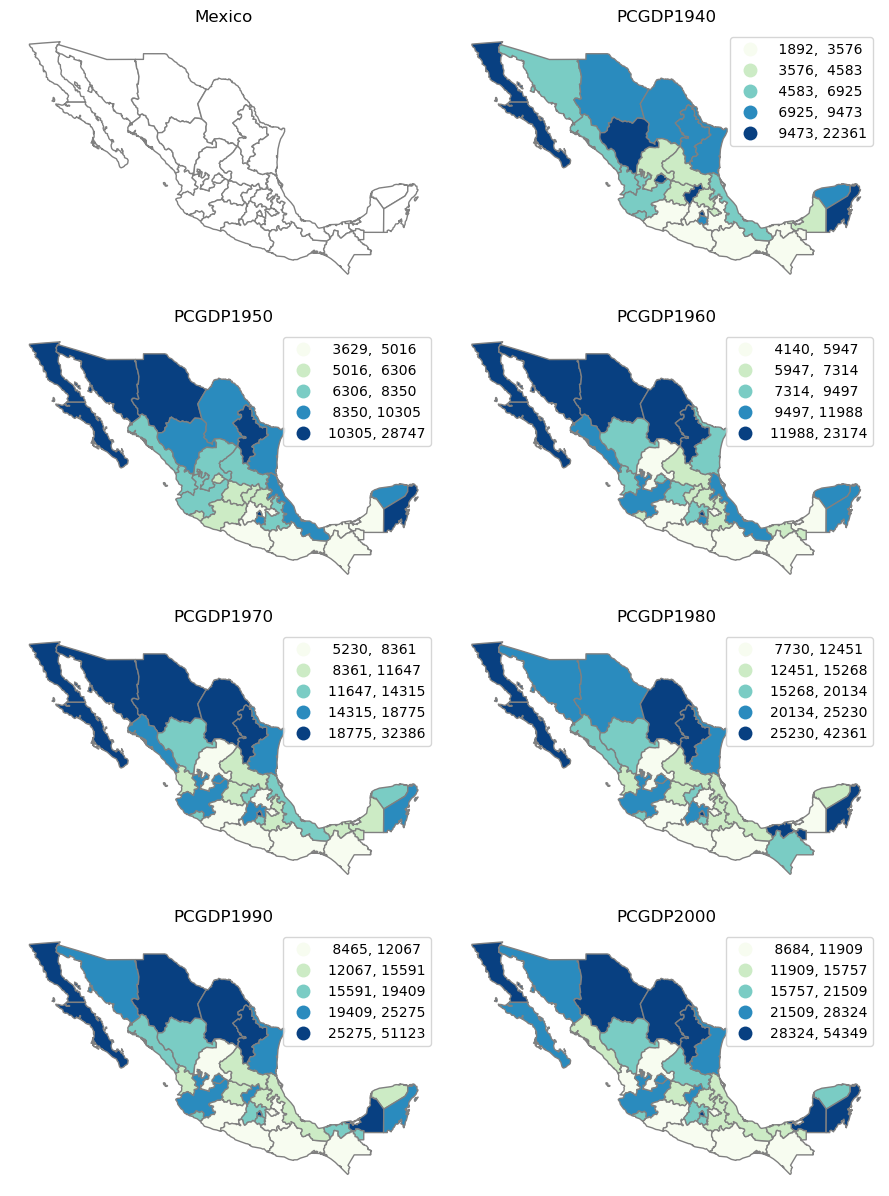

In [6]:
subplotter(mexico, mxgdp_years_grid, None)

In [7]:
attrs_name = [f"PCGDP{year}" for year in mxgdp_years[1:]]
attrs_name

['PCGDP1940',
 'PCGDP1950',
 'PCGDP1960',
 'PCGDP1970',
 'PCGDP1980',
 'PCGDP1990',
 'PCGDP2000']

In [8]:
w = libpysal.weights.Queen.from_dataframe(mexico)

C:\Users\50476\AppData\Local\Temp\ipykernel_25912\788430221.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(mexico)


In [10]:
threshold = 6
top_n = 2
mexico["count"] = 1
threshold_name = "count"
import numpy
numpy.random.seed(RANDOM_SEED)
model = MaxPHeuristic_IG(mexico, w, attrs_name, threshold_name, threshold, top_n)
model.solve()

In [11]:
model.p

5

In [12]:
mexico["maxp_new"] = model.labels_
mexico[["maxp_new", "AREA"]].groupby(by="maxp_new").count()

,AREA
maxp_new,
1,6
2,7
3,6
4,7
5,6


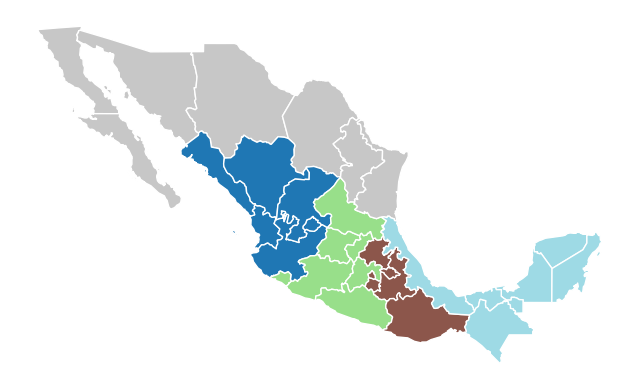

In [13]:
mexico.plot(figsize=(8, 5), column="maxp_new", cmap="tab20", edgecolor="w").axis("off");